---
title: Explainable AI for Spotify?
description: 'Did you ever wonder how Spotify, Tidal or YouTube work? Why are they suggesting a song to you?. Sometimes the suggestions are quite good. Read this article and see how we reveal some mysteries about automatic playlists.'
date: '2025-07-15'
categories:
- deep learning
- python
- audio ML
- explainable AI
execute:
  message: false
  warning: false
editor_options:
  chunk_output_type: console
toc: true
number-sections: true  
output-file: mini-spotify-deejai-xai
---

## Playing DJ

I recently got to play DJ at a private party. Usually, this involves endless hours of listening through songs. You then try to figure out what track fits best where, how to build energy, and what to avoid. It is like a radio DJ with a static playlist. Creating a static playlist that matches the vibe at different times throughout the night can be tough work.

But now we have AI. Everything is soo easy.

That was my state of mind, when I started with [Deej-AI](https://github.com/teticio/Deej-AI).

My idea was simple: tell the AI what music I like and let it handle the playlist. With clear instructions provided by the creator in the repository, I anticipated having my perfect playlist ready in no time.


### Playlist creation with Deej-AI

I started by selecting a few hundred songs I love. I did not care much about the order or proportion of style, hoping the software would seamlessly fill in the gaps. Running the software quickly generated playlists, which looked okayish at a first glance. Looking deeper, imperfections began to show. As I preferred no song repetitions, the playlist noticeably deteriorated towards the end when the algorithm ran out of optimal matches.

This highlighted a crucial issue of Deej-AI: the lack of global optimization. Deej-AI could suggest suitable songs individually but struggled to maintain consistency and match the overall mood progression throughout the evening.
Think of a good mixtape or a carefully curated DJ playlist. The AI creation was the opposite.

Respecting different times of day and specific moods was impossible due to the absence of a robust global layout editor. Even though the software offered gap-filling functionality, it still required explicit instructions about what was missing. In the end, creating a truly seamless playlist still required significant manual effort.


### Why did the computer pick song A over song B?
Despite the lack of features, the picks sometimes pleasantly surprised me; sometimes just surprised.
This curiosity led me deeper: why exactly was one song selected over another?

In this article, we'll explore these choices through three lenses:

We will examine our data at three different scales

- **Macro-level** with t-SNE visualization: to reveal groups of songs and overall patterns in the playlist.

- **Meso-level** with Grad-CAM: highlighting crucial parts of audio spectrograms that influenced song selection.

- **Micro-level** with Integrated Gradients: examining the precise contribution of individual audio features.


By dissecting these layers of explainability, I'll show how your favourite music app works on auto-listening. I hope this is not only valuable for developers, but anybody wondering about why he often ends up with mainstream music on YouTube .

## Music, just another form of Data
Before we dive into the tools, let's first clarify what our data looks like.
In the following, we look at metadata, audio and embeddings.

### Theme metadata
To help the tool generate better playlists, I divided the day into two distinct segments: a calm part and a more energetic, danceable part. We'll store this information as metadata and revisit it later in our analysis.


We note which song is in which sublist, as we will require this later.

In [1]:
#| code-fold: true
import csv
from pathlib import Path

import pandas as pd


def create_manifest():
    with open("/app/data/raw-previews/explainabletrack_manifest.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "theme"])

        for theme_dir in Path("/app/data/raw-previews/separate").iterdir():
            if theme_dir.is_dir():
                theme = theme_dir.name
                for audio_file in theme_dir.glob("*.mp3"):
                    writer.writerow([audio_file.name, theme])

In [2]:
create_manifest()

We now have a table with data, also called tabular data. Your music provider has much bigger tables with a lot more columns (genre, speed, mood, ...). For simplicity, we restrict ourselves. Let's look at the data.

In [3]:
manifest = pd.read_csv("/app/data/raw-previews/explainabletrack_manifest.csv")
manifest.head()

,filename,theme
0,With Or Without You - U2.mp3,ruhig
1,La javanaise - Serge Gainsbourg.mp3,ruhig
2,Djadja - Aya Nakamura.mp3,ruhig
3,Le chant des sirènes - Fréro Delavega.mp3,ruhig
4,start.mp3,ruhig


And recheck the count in the two categories.

In [4]:
manifest.theme.value_counts()

theme
party    129
ruhig    116
Name: count, dtype: int64



::: {.callout-note collapse="true"}
#### Paths in this notebook
I use a dockerized version of Deej-Ai, which can be found on my GitHub. Therefore, paths are inside the docker, this is why paths sometimes start with `/app` and sometimes with `/opt`.
:::


### Audio data

We are going to study sound signals. Sound is usually analyzed with the help of a spectrogram.
While a lot more complex models exist, spectrogram can be just processed as images.
This allows us to a simple classification analysis with something as simple as `Resnet` model.


The following picture shows a spectrogram. On the x-axis is the time.
The y-axis shows the frequencies. The color is the amplitude of the wave form at this frequency and time.


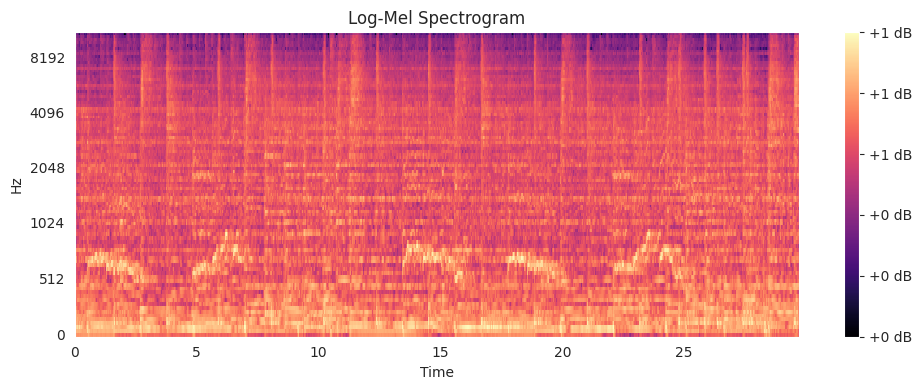

In [5]:
#| code-fold: true
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load audio
filename = '/app/data/raw-previews/combined/Purple Rain - Prince.mp3'
y, sr = librosa.load(filename, sr=22050)

# Create log-Mel spectrogram, this converts the waveform into a picture
n_fft = 2048
hop_length = 512
n_mels = 96

S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length, n_mels=n_mels)
log_S = librosa.power_to_db(S, ref=np.max)

# normalize the spectogram for further processing
log_S = (log_S - np.min(log_S)) / (np.max(log_S) - np.min(log_S))

plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log-Mel Spectrogram")
plt.tight_layout()
plt.show()


#### Slicing images
We use spectrogram images to classify the songs. The procedure is identical to your favourite bear or chesse classifier. However, classifying the full spectrogram of one song as a whole is often not very helpful. The songs are usually defined by local features. We either need a more complex model than a CNN, or we reduce the data the CNN sees. In practice, the latter option means we are going to slice the image.

For the study, we use spotify track previews. They usually provide a good sample of the track itself. A more comprehensive analysis would study the whole track and respect intra-track variation.

Let's slice a track.


In [6]:
def slice_image(slice_size=216, stride=216):
    slices = []
    starts_sec = []
    for start in range(0, log_S.shape[1] - slice_size + 1, stride):
        end = start + slice_size
        slices.append(log_S[:, start:end])
        start_sec = start * hop_length / sr
        end_sec = end * hop_length / sr
        starts_sec.append((start_sec, end_sec))
    return slices, starts_sec

slices, starts_sec = slice_image()
print("Number of slices", len(slices))

Number of slices 5


Let's create a side-by-side view of full spectrogram and slices

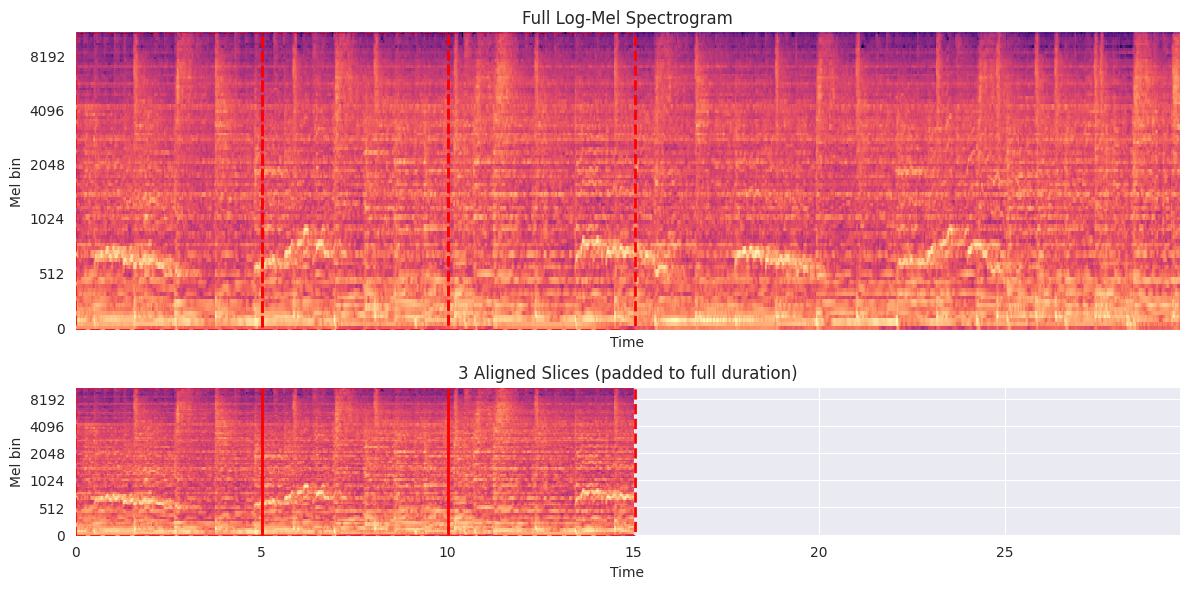

In [7]:
#| code-fold: true

num_slices_to_show = 3
fig, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

## Plot full spectrogram
librosa.display.specshow(log_S, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', ax=axs[0])
axs[0].set_title("Full Log-Mel Spectrogram")
axs[0].set_ylabel("Mel bin")

# Overlay slices
for i in range(min(num_slices_to_show, len(slices))):
    start, end = starts_sec[i]
    axs[0].axvspan(start, end, edgecolor='red', facecolor='none', lw=2, linestyle='--')

# Slice image
## Slices stitched together horizontally, padded to full time width
slice_canvas = np.zeros_like(log_S) * np.nan  # fill with NaNs

for i in range(min(num_slices_to_show, len(slices))):
    start_frame = int(starts_sec[i][0] * sr / hop_length)
    slice_data = slices[i]
    slice_canvas[:, start_frame:start_frame + slice_data.shape[1]] = slice_data

librosa.display.specshow(slice_canvas, sr=sr, hop_length=hop_length,
                         x_axis='time', y_axis='mel', ax=axs[1])

for i in range(min(num_slices_to_show, len(slices))):
    start, end = starts_sec[i]
    axs[1].axvspan(start, end, edgecolor='red', facecolor='none', lw=2, linestyle='--')

axs[1].set_title(f"{num_slices_to_show} Aligned Slices (padded to full duration)")
axs[1].set_ylabel("Mel bin")

plt.tight_layout()
plt.show()


Finally, let's define a function for slicing which we will be using later.

In [32]:
def mp3_to_slices(path):
    N_MELS = 96
    SLICE_SIZE = 216  # must match model input
    y, sr = librosa.load(path, sr=22050)
    S = librosa.feature.melspectrogram(y=y, sr=22050, n_fft=2048,
                                       hop_length=512, n_mels=N_MELS, fmax=sr / 2)
    x = np.ndarray(shape=(S.shape[1] // SLICE_SIZE, N_MELS, SLICE_SIZE, 1), dtype=float)

    # we use the original code to get the same input batch size
    for slice in range(S.shape[1] // SLICE_SIZE):
        log_S = librosa.power_to_db(S[:, slice * SLICE_SIZE: (slice + 1) * SLICE_SIZE], ref=np.max)
        if np.max(log_S) - np.min(log_S) != 0:
            log_S = (log_S - np.min(log_S)) / (np.max(log_S) - np.min(log_S))
        x[slice, :, :, 0] = log_S

    return x

### Embeddings
Instead of working with the spectrogram images in the model, the author of Deej-AI has done something a little bit more complex.
He was not interested in knowing which song sounds similar to another, but which songs are usually played together. From this knowledge, he inferred that similar sounding new songs could be also played together with songs in the database.

The understanding of song lyrics and context is implicit in the playlists.

He therefore first encoded many playlists and then matched the spectrograms against this in another training.

The complete Training Inference Pipeline can be visualized like this.

```{mermaid}
%%| fig-width: 3.5
---
format:
  html:
    mermaid:
      theme: neutral
---
flowchart TB
  %% === Training #1: Track2Vec ===
  subgraph T1[Training #1: Track2Vec]
    A1[Audio Files] --> |Organize| B1[Playlists]
    B1 --> |Train Track2Vec| C[100D Embeddings]
  end


  %% === Training #2: Mp3ToVec ===
  subgraph T2[Training #2: Mp3ToVec]
    D1[Audio Files] -->|Convert & Slice| E1[Log-Mel Spectrograms]
    C --> |Use| F1[Embeddings as Labels]
    E1 -->  E2[Training Input]
    F1 -->  E2[Training Input]
    E2 --> |Train with Cosine Similarity Loss| G1[CNN with 100D Output]
  end

  %% === Inference ===
  subgraph INF[Inference]
    I1[Audio Files] --> |Convert & Slice| I2[Log-Mel Spectrograms]
    G1 --> |Use| I3[Inference Model]
    I2 --> I4[Inference Input]
    I3 --> I4[Inference Input]
    I4 --> |run model| I5[100D Embeddings]
    I6[Query Idx] --> |Cosine Similarity to Find Similar Songs To Query| I7[Best Next Song]
    I5 --> I6
  end

    subgraph t[Training]
        T1
        T2

    end
```

Instead of using strings as `Labels`, the embeddings from the Spotify playlist-based Training act as such. Therefore, it is better to speak of dependent variable $y$. Our labels have the dimension of 100. The second network is a standard classification.

During inference, the predicted output for every spectrogram is a 100D vector. The spectrogram acts as features $X_{inf}$. In a final step, we rank songs by the best fit to our query.

To answer our questions "Why was song A chosen?" we only need to analyze the inference related to training #2.

We already had a look at $X$. Now let's look at the dependent variable $y$.

## T-SNE for high dimensionality data.
We are interested in visualizing our labels. I ran the embedding creation in `Deej-Ai` with `MP3ToVec`. This is done via `model.predict(x)`. Where $x$ are the slices we defined earlier. The data was then stored.


In [8]:
import pickle

filenames = ['/opt/project/data/raw-previews/combined/' + f for f in manifest['filename']]

with open("/app/data/pickles/combined/mp3tovecs/mp3tovec.p", "rb") as f:
    mp3tovecs = pickle.load(f)

X = np.vstack([mp3tovecs[f] for f in filenames if f in mp3tovecs])



The issue, the data is of the form 100D for each file. How to visualize this. A straightforward approach would be a matrix plot.


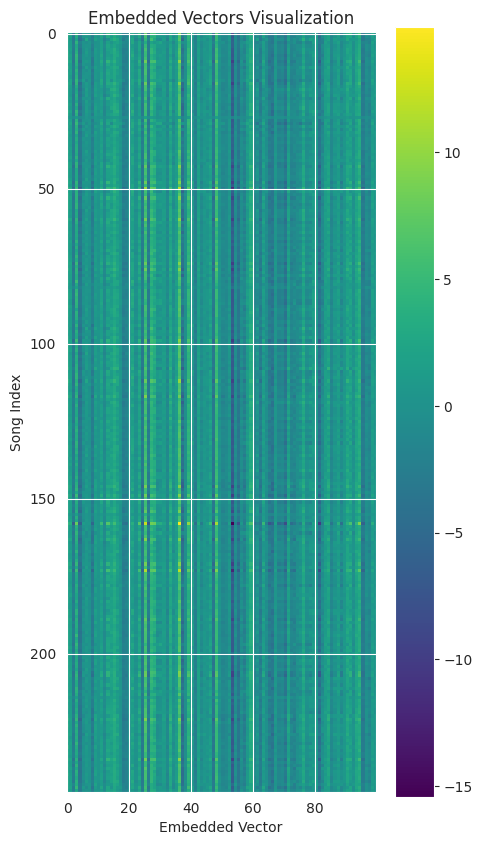

In [9]:
#| code-fold: true
plt.figure(figsize=(5, 10))
plt.imshow(X, cmap='viridis')
plt.colorbar()
plt.title("Embedded Vectors Visualization")
plt.ylabel("Song Index")
plt.xlabel("Embedded Vector")
plt.show()

From this we can actually not see much. Only that many dimensions are characteristic in their value (vertical lines)

We need to reduce the dimensions to plot this data in a scatter plot.
T-distributed stochastic neighbor embedding (TNSE) is a popular dimensionality reduction technique. You can read more on [wikipedia](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). But as with any complex method, there are some caveats. A nice article about the limitations is in [distill.pub](https://distill.pub/2016/misread-tsne/).

### T-SNE Limitations TL;DR;

- Distances are not reliable: Global structure is often distorted; distances between clusters are meaningless.
- Cluster sizes are misleading: Size/shape doesn't reflect actual data density or variance.
- Clusters can be artifacts: t-SNE can create apparent groupings even from random data.
- Sensitive to hyperparameters: Perplexity, learning rate, and iterations drastically affect results.
- Non-deterministic: Results vary with different random seeds; always run multiple times.
- No generalization: Can't project new data without retraining (non-parametric).
- Slow on large datasets: Scales poorly; approximations or UMAP may be better.

### T-SNE Best Practice TL;DR;

- Tune parameters carefully.
- Run multiple times to check stability.
- Don’t trust distances, cluster sizes, or shapes.
- Use it for exploration, not clustering or quantification.
- Compare with PCA, UMAP, or other embeddings.

In short, the main issue is the sensitive to the hyperparameters. A recent paper, [Gove et al. 2022](https://www.sciencedirect.com/science/article/pii/S2468502X22000201), came up with a comprehensive study. In contrast to a previous study [Kobak and Berens, 2019](https://www.sciencedirect.com/science/article/pii/S2468502X22000201#b19), the authors found no dependence on the size of the dataset (previously 1% of dataset size). The previous results translate to perplexity of 2.5. This means any point is just influenced by 2 other points. This often overstressed the local structure. Instead, we focus on the newer `magic recipe`.

### The magic recipe
Here is a summary of the findings:

Begin with
```python
perplexity = 16
learning_rate = 10
exaggeration = 1
iters = 1000 # Above 1000 iters low variation
```

Then tune by visual inspection

- Blobs? → raise exaggeration to 3–4.
- Lost global shape? → double learning-rate or bump perplexity (never past 16).
- Over-compressed? → lower exaggeration or learning-rate.

Big data (≫20 k points): try perplexity ≈ n/100 and lr ≈ n/12.


### T-SNE for the playlist data
Let's apply these findings to our data. To check the stability of the result, we treat this as a convergence issue and write a function that checks the solution for stability.

In [10]:
from sklearn.manifold import TSNE


def tsne_until_converged(
        X,
        step_iter=250,
        max_iter=10000,
        tol=1e-3,
        random_state=42,
        verbose=True,
        perplexity=5,
        learning_rate=10,
        exaggeration=1
):
    n = X.shape[0]

    common = dict(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        early_exaggeration=exaggeration,
        init="pca",
        random_state=random_state,
        verbose=False,
    )

    # we always start at 250
    total_iter = 250
    tsne = TSNE(max_iter=total_iter, **common)
    Y = tsne.fit_transform(X)

    history = []
    prev = Y.copy()

    while total_iter < max_iter:
        total_iter += step_iter
        tsne = TSNE(
            max_iter=total_iter,
            **common,
        )
        Y = tsne.fit_transform(X)

        # Check the stability
        delta = np.linalg.norm(Y - prev, axis=1).mean()
        history.append(delta)
        if verbose:
            print(f"[{total_iter + step_iter} iters] mean move = {delta:.6f}")

        if delta < tol:
            if verbose:
                print("✓ Converged")
            break

        prev = Y.copy()

    return Y, history, total_iter

Here are my iterations, which I did follow the `magic recipe`.

In [11]:
%%capture
embedding1, movement1, max_iter1 = tsne_until_converged(X)

In [12]:
%%capture
embedding2, movement2, max_iter2 = tsne_until_converged(X, perplexity=10)

In [156]:
%%capture
embedding3, movement3, max_iter3 = tsne_until_converged(X, perplexity=16)

In [157]:
%%capture
embedding4, movement4, max_iter4 = tsne_until_converged(X, perplexity=16, exaggeration=4)

In [ ]:
%%capture
embedding5, movement5, max_iter5 = tsne_until_converged(X, perplexity=16, exaggeration=4, learning_rate=40)

Let's plot the 2D data and the stability of the embeddings.

In [ ]:
#| code-fold: true
# for plotting we define a helper function
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def plot_tsne_results(
        results,
        filenames=None,
        titles=None,
        palette="Set2",
        figsize=(6, 12),
):
    n = len(results)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(figsize[0] * n, figsize[1] * 2))

    for i, (embedding, movement) in enumerate(results):
        # 1. Plot embedding
        tsne_df = pd.DataFrame({
            "x": embedding[:, 0],
            "y": embedding[:, 1],
            "label": filenames if filenames is not None else [""] * len(embedding)
        })

        ax1 = axes[i, 0] if n > 1 else axes[0]
        sns.scatterplot(
            data=tsne_df,
            x="x", y="y",
            hue="label",
            palette=palette,
            s=60, edgecolor='k', alpha=0.7,
            ax=ax1,
            legend=False if i > 0 else "auto"
        )
        ax1.set_title(titles[i] if titles else f"t-SNE Embedding {i + 1}")
        ax1.set_xlabel("TSNE-1")
        ax1.set_ylabel("TSNE-2")

        # 2. Plot movement curve
        ax2 = axes[i, 1] if n > 1 else axes[1]
        ax2.plot(movement, marker='o', linewidth=1.5)
        ax2.set_title("Mean Movement per Step")
        ax2.set_xlabel("Step")
        ax2.set_ylabel("Mean Δ Position")
        ax2.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
#| code-fold: true
results = [
    (embedding1, movement1),
    (embedding2, movement2),
    (embedding3, movement3),
    (embedding4, movement4),
    (embedding5, movement5),
]

plot_tsne_results(results, titles=["Run 1 p=5", "Run 2 p=10", "Run 3 p=16", "Run 4 p=16,e=3", "Run 5 p=16,e=3, l=40"])

There is not much variation. There are three distinctive groups in all pictures. The standard setting in run2 leads to vertically squeezed distribution. The result in this respect seems better in run 5, with early exaggeration and increased learning rate.

### Can we see two groups (party and quite) in the data?
As mentioned earlier, I was not entirely happy with the matches. As a result, triaged the files into two groups. One which I experienced as quiet. Let's see if we can confirm this very subjective impression in the data, even though we never told the model that these two groups exist.

We define the data to be plotted to include theme and filename.

In [161]:
#| code-fold: true
# Load manifest again
manifest = pd.read_csv("/app/data/raw-previews/explainabletrack_manifest.csv")
labels = [f for f in manifest['theme']]
tsne_df = pd.DataFrame({
    "x": embedding5[:, 0],
    "y": embedding5[:, 1],
    "theme": labels,
    "filename": filenames
})

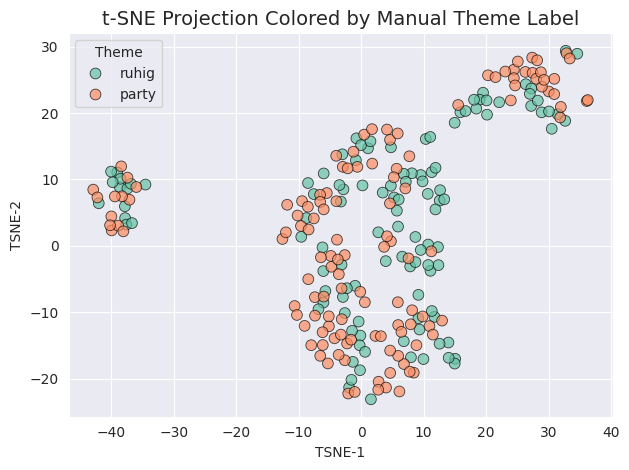

In [162]:
#| code-fold: true
sns.scatterplot(
    data=tsne_df,
    x='x', y='y',
    hue='theme',
    palette='Set2',
    s=60, edgecolor='k', alpha=0.7
)

plt.title("t-SNE Projection Colored by Manual Theme Label", fontsize=14)
plt.xlabel("TSNE-1");
plt.ylabel("TSNE-2")
plt.legend(title="Theme")
plt.tight_layout()
plt.show()

Overall, the data does not fit the perceived feature of "quietness." The only think that is noticeable in the picture is a clustering of green points to the left and the bottom of the patch 2 and 3, respectively.

#### Intra- and inter-theme similarity
We can express this in numbers and calculate intra- and inter-theme similarity. The themes should be distinct and have little variation.

In [163]:
#| code-fold: true
from sklearn.metrics.pairwise import cosine_distances
import itertools

theme_to_indices = tsne_df.groupby("theme").groups
theme_names = list(theme_to_indices.keys())

similarity_stats = []

for t1, t2 in itertools.combinations_with_replacement(theme_names, 2):
    i1 = list(theme_to_indices[t1])
    i2 = list(theme_to_indices[t2])

    vec1 = X[i1]
    vec2 = X[i2]

    distances = cosine_distances(vec1, vec2)
    mean_distance = distances.mean()

    similarity_stats.append({
        "theme_1": t1,
        "theme_2": t2,
        "mean_cosine_distance": mean_distance
    })

similarity_df = pd.DataFrame(similarity_stats)
similarity_df.sort_values(by="mean_cosine_distance", inplace=True)
similarity_df

,theme_1,theme_2,mean_cosine_distance
0,party,party,0.040207
2,ruhig,ruhig,0.046004
1,party,ruhig,0.048002


In [164]:
#| code-fold: true
from sklearn.metrics import silhouette_score

score = silhouette_score(X, labels, metric='cosine')
print(f"Silhouette Score (cosine): {score:.3f}")

Silhouette Score (cosine): 0.085


All of these numbers are very close to zero. This data backs the visual impression: The manual groups have nothing to do with the automatic selection. This explains why I was not satisfied. Features that I deemed important are somehow not in the data. Interesting.

### Similarity analysis of single songs
Let's study more how the model behaves with respect to a query.
Our query song is Purple Rain - Prince.

My final playlist had this ordering

- Luna - Bombay Bicycle Club.mp3
- Purple Rain - Prince.mp3
- Everybody Wants To Rule The World - Tears For Fears.mp3
- Kiss from a Rose - Seal.mp3


We first define some helpers

In [166]:
from sklearn.metrics.pairwise import cosine_similarity

def get_vector_by_name(db, search_term):
    return db["/opt/project/data/raw-previews/combined/" + search_term + ".mp3"]


def compare_songs(song_A, song_B, db):
    song_A_vec = get_vector_by_name(db, song_A)
    song_B_vec = get_vector_by_name(db, song_B)

    sim = cosine_similarity(song_A_vec.reshape(1, -1), song_B_vec.reshape(1, -1))[0][0]
    print(f"Similarity to {song_A}: {sim:.3f}")


def most_similar_song(song_A_vec, vectors, filenames):
    sims = cosine_similarity(song_A_vec.reshape(1, -1), vectors)[0]
    min_idx = np.argmin(sims)
    min_score = sims[min_idx]

    print(f"Weakest match cosine similarity: {min_score:.3f}")
    sorted_indices = np.argsort(sims)[::-1]  # Descending order

    second_idx = sorted_indices[1]

    return filenames[second_idx], sims[second_idx]


Let's see what is the best fitting song to `Purple Rain`.

In [171]:
best_match, score = most_similar_song(get_vector_by_name(mp3tovecs, "Purple Rain - Prince"), X, filenames)
print(f"Best match: {best_match} — cosine sim: {score:.3f}")


Weakest match cosine similarity: 0.825
Best match: /opt/project/data/raw-previews/combined/Mesmerise - Temples.mp3 — cosine sim: 0.999


Again, we confirm that the automatic matching produced something different from my selection. Let's compare all songs and also one which is completely off.

In [172]:
compare_songs("Purple Rain - Prince", "Everybody Wants To Rule The World - Tears For Fears", mp3tovecs)

Similarity to Purple Rain - Prince: 0.998


In [173]:
compare_songs("Purple Rain - Prince", "Luna - Bombay Bicycle Club", mp3tovecs)

Similarity to Purple Rain - Prince: 0.995


In [174]:
compare_songs("Purple Rain - Prince", "Mr. Brightside - The Killers", mp3tovecs)

Similarity to Purple Rain - Prince: 0.933


In [175]:
compare_songs("Purple Rain - Prince", "Kiss from a Rose - Seal", mp3tovecs)

Similarity to Purple Rain - Prince: 0.990



#### Plotting single songs in TSNE plot
As a final step, we want to visualize what we have just expressed in numbers. How are the songs related to the plot?

In [176]:
#| code-fold: true
labels = ["none"] * len(filenames)

songs = ["Purple Rain - Prince", "Mesmerise - Temples", "Everybody Wants To Rule The World - Tears For Fears",
         "Mr. Brightside - The Killers", ]

for i, f in enumerate(filenames):
    for song in songs:
        if song in f:
            labels[i] = song
            break

tsne_df = pd.DataFrame({
    "x": embedding5[:, 0],
    "y": embedding5[:, 1],
    "theme": labels,
    "filename": filenames
})

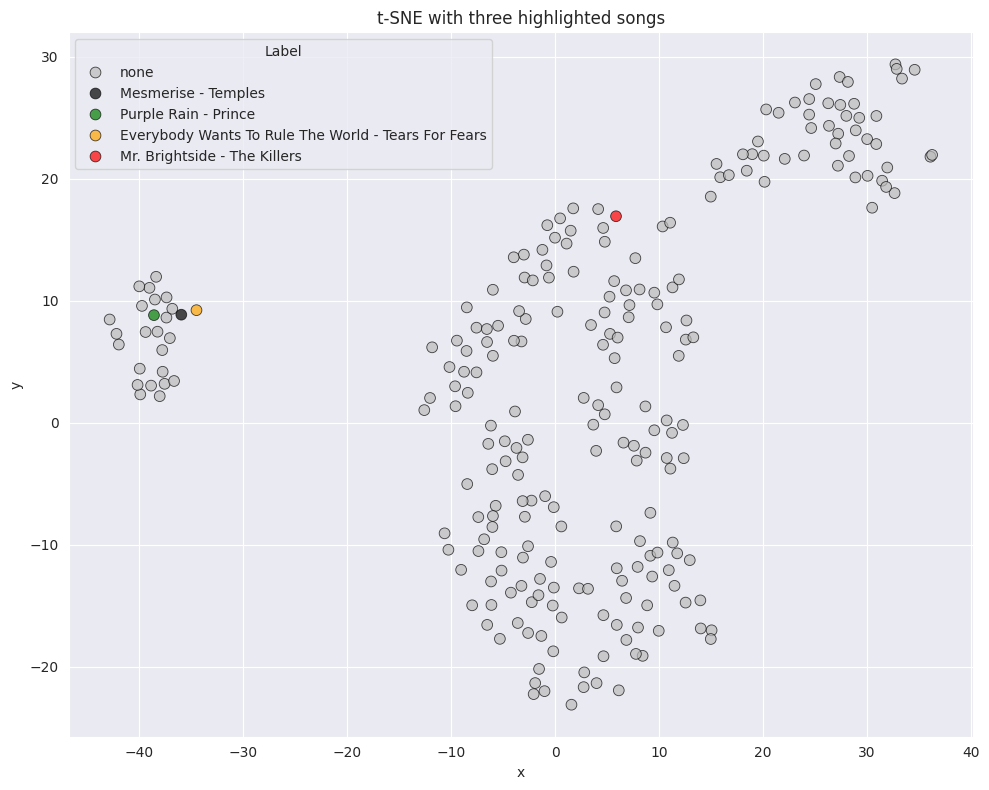

In [177]:
#| code-fold: true
palette = {
    "none": "#bbbbbb",
    songs[1]: "black",
    songs[0]: "green",
    songs[2]: "orange",
    songs[3]: "red",

}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x="x", y="y",
    hue="theme", hue_order=["none", songs[1], songs[0], songs[2], songs[3]],
    palette=palette,
    s=60, edgecolor="k", alpha=0.7
)
plt.legend(title="Label", loc="best")
plt.title("t-SNE with three highlighted songs")
plt.tight_layout()
plt.show()

The picture confirms it again. `Temples - Mesmerise` is the best match. It should have been picked. It appears The nearby match `Everybody Wants To Rule The World - Tears For Fears` was not the closest match and only got taken because I interfered with the playlist creation.

## Grad-CAM
Our Mp3ToVec network already tells us how close two songs are (cosine similarity), but not where that closeness comes from.

Are there any regions in the spectrogram that lead to the exact match?
Which time–frequency zones triggered the network to declare “this query sounds like Song A (and not Song B)".
In the next section, we will look at Integrated Gradients, which observes down to pixel level. Grad-CAM offers a complementary, big-picture view.

### Background
Grad-CAM works by examining the last convolutional layer, which acts as the model’s feature detector.
We then use the gradient of the similarity score with respect to Song A to weight these feature maps.

Finally, we project the weighted activation maps back onto the spectrogram. This results in a coarse heatmap; red blobs where the CNN focused, and blank areas elsewhere.

In terms of interpretability, this allows a visual inspection, which goes beyond simple scores.

### Implementation

In [23]:

from tensorflow.keras.models import load_model
import tensorflow as tf
model = load_model(
    '/app/speccy_model',
    custom_objects={
        'cosine_proximity':
            tf.compat.v1.keras.losses.cosine_proximity
    })
model.trainable = False;
conv_layer = model.get_layer("separable_conv2d_3")

In [25]:
from scipy.ndimage import gaussian_filter


def score_fn(emb):
    emb = tf.nn.l2_normalize(emb, axis=1)
    return tf.tensordot(emb, vec_A, axes=1)
    
def grad_cam(slice_tensor,
             model, conv_layer, score_fn,
             eps=1e-8):
    # build a model that gives conv feature-maps and final embedding
    grad_model = tf.keras.Model(
        inputs=model.inputs,
        outputs=[conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(slice_tensor)
        tape.watch(conv_out)
        score = score_fn(preds)

    
    grads = tape.gradient(score, conv_out) 
    weights = tf.reduce_mean(grads, axis=[1, 2])

    cam = tf.reduce_sum(weights[:, None, None, :] * conv_out, axis=-1)[0] 
    cam = tf.nn.relu(cam)

    cam = tf.image.resize(cam[..., None], slice_tensor.shape[1:3])[..., 0]
    cam = (cam - tf.reduce_min(cam)) / (tf.reduce_max(cam) - tf.reduce_min(cam) + eps)
    return cam.numpy()


def full_song_grad_cam(model, query_slices, vec_A, conv_layer,
                       n_mels=96, slice_size=216, sigma=1.5):
    
    vec_A_tf = tf.constant(vec_A / np.linalg.norm(vec_A), tf.float32)

    def score_fn(embedding):
        return tf.tensordot(tf.nn.l2_normalize(embedding, axis=1), vec_A_tf, axes=1)
        
    gc_full = np.zeros((n_mels, query_slices.shape[0] * slice_size))

    for i, slice_tensor in enumerate(query_slices):
        slice_tensor = slice_tensor[None, ...]
        gc = grad_cam(slice_tensor, model, conv_layer, score_fn)
        gc = gaussian_filter(gc, sigma=sigma)
        gc_full[:, i * slice_size: (i + 1) * slice_size] = gc
        
    return gc_full

Now that we have defined a function to do GRAD-CAM for the full song. Let's study the difference for song A and song B. We will get an answer which regions where more important to which song and which were identically important.

In [27]:
vec_A = mp3tovecs['/opt/project/data/raw-previews/combined/Mesmerise - Temples.mp3']
vec_B = mp3tovecs['/opt/project/data/raw-previews/combined/Everybody Wants To Rule The World - Tears For Fears.mp3']
x_query = mp3_to_slices('/app/data/raw-previews/combined/Purple Rain - Prince.mp3')

In [30]:
cam_A = full_song_grad_cam(model, x_query, vec_A, conv_layer)
cam_B = full_song_grad_cam(model, x_query, vec_B, conv_layer)

# we use signed log, as the songs are very close together.
diff = tf.math.log((cam_A + 1e-5) / (cam_B + 1e-5))
diff_clipped = tf.clip_by_value(diff, -3.0, 3.0)

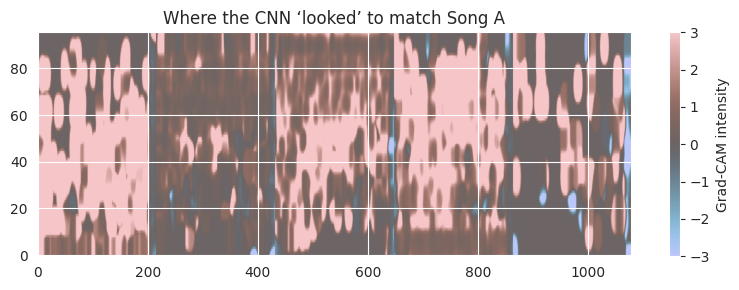

In [31]:
#| code-fold: true
plt.figure(figsize=(8, 3))

plt.imshow(diff_clipped, cmap="berlin", alpha=0.6, origin="lower", aspect="auto")
plt.colorbar(label="Grad-CAM intensity")
plt.title("Where the CNN ‘looked’ to match Song A")
plt.tight_layout();
plt.show()

Thanks to the clipping, the graph is easy to read. The Song had a lot more information, which made it similar to the query song.

Only at the very end are some blue spots. This could indicate that the spotify preview covers only the less relevant sections of the entire song for the particular comparison. Whereas I was listening to the full song. Song B seems better for the rhythm as the blue patches repeat.

We will dive deeper into this in the next section.

## Integrated gradients
Why did the model prefer Song A over Song B?
We know that the model turns spectrograms into 100-D vectors and ranks candidates using cosine similarity. That alone doesn't tell us why one track got a higher score than another.
To dig deeper, we use Integrated Gradients (IG).
This method helps identify which parts of a spectrogram contribute most to the similarity score, that is which pixels or frequencies increase the score.

In contrast to Grad-Cam, we do not look at the feature level, but on input level through the entire network.

### Background
IG works by comparing the actual input (the spectrogram) to a baseline input, typically silence.

We then gradually transition from the baseline to the real input by scaling the spectrogram with a factor $\alpha$.

$$ x_α = baseline + \alpha × (input - baseline) $$

where $\alpha ∈ [0,1]$

At each step, we compute the gradient of the output with respect to the input. When we average across all steps, we get the average contribution of each pixel.

In `Pytorch` we have the `Captum` library to directly do this. However, `Deej-AI` works on an older keras 2.13. We need to implement Integrated Gradients from scratch.


### From scratch development of integrated gradients

#### Method for one slice

We define the integrated gradients for one slice

Let's first clarify what we expect from the model

Luckily for a linear model
$$f(x) = w^\top x + b$$

the Integrated Gradients have the closed-form

$$\mathrm{IG}(x) \;=\; (x - x_0)\,\odot\,w$$

We intend to use integrated gradients to check the impact on the cosine similarity score. Therefore, we need to integrate the L2 norm in the function. This has side effects in testing. We need to make the code modular to accommodate for this.

In [178]:
import tensorflow as tf

# for testing, we will test on raw attribution without normalization
def default_score_fn(preds, target_vec=None):
    if target_vec is not None:
        t = tf.reshape(tf.convert_to_tensor(target_vec, tf.float32), [-1])
        return tf.reduce_sum(preds * t, axis=-1)
    else:
        return tf.reduce_sum(preds, axis=-1)


# we are interested on the effect of the cosine similarity score, therefore, we will need to do L2
def cosine_score_fn(preds, target_vec):
    p = tf.nn.l2_normalize(preds, axis=1)
    t = tf.nn.l2_normalize(target_vec, axis=0)
    return tf.reduce_sum(p * t, axis=-1)


# this is the function for one slice
def ig_one_slice(
        model,
        query_slice,
        target_vec,
        baseline_slice=None,
        steps=120,
        score_fn=default_score_fn
):
    if baseline_slice is None:
        baseline_slice = tf.zeros_like(query_slice, dtype=tf.float32)

    # make sure we work on f32
    query_slice = tf.convert_to_tensor(query_slice, dtype=tf.float32)
    baseline_slice = tf.convert_to_tensor(baseline_slice, dtype=tf.float32)
    if target_vec is not None:
        target_vec = tf.convert_to_tensor(target_vec, dtype=tf.float32)
        target_vec = tf.reshape(target_vec, [-1])

    # Remove batch dim for interpolation
    start = tf.squeeze(baseline_slice, 0)  # (96,216,1)
    end = tf.squeeze(query_slice, 0)  # (96,216,1)

    alphas = tf.linspace(0.0, 1.0, steps)[:, tf.newaxis, tf.newaxis, tf.newaxis]
    interpolated = start + alphas * (end - start)

    # Compute gradients
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        scores = score_fn(preds, target_vec)

    grads = tape.gradient(scores, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)

    ig = (end - start) * avg_grads
    return ig

Gradients can be noisy. We add some smoothing to get a better visual representation. We use a two-pass smoothing. First on the slice and later on the final output.

In [179]:
from scipy.ndimage import gaussian_filter

def ig_one_slice_smooth(
        model,
        query_slice,
        target_vec=None,
        baseline_slice=None,
        steps=120,
        score_fn=default_score_fn,
        sigma=0
):
    ig_raw = ig_one_slice(
        model=model,
        query_slice=query_slice,
        target_vec=target_vec,
        baseline_slice=baseline_slice,
        steps=steps,
        score_fn=score_fn
    )

    ig_map = ig_raw.numpy().squeeze()
    return gaussian_filter(ig_map, sigma=sigma)

#### Testing with a closed form solution

In [180]:
#| code-fold: true
def test_for_ig_one_slice():
    H, W = 2, 3

    flat_vals = np.arange(H * W, dtype=np.float32)  # [0, 1, 2, 3, 4, 5]
    x = flat_vals.reshape((1, H, W, 1))  # shape: (1,2,3,1)
    x = tf.constant(x)

    x0 = tf.zeros_like(x)  # shape: (1,2,3,1)

    w = tf.constant(flat_vals, dtype=tf.float32)  # weights = [0,1,2,3,4,5]
    b = tf.constant(0., dtype=tf.float32)

    class LinearModel(tf.keras.Model):
        def __init__(self, w, b):
            super().__init__()
            self.w = w
            self.b = b

        def call(self, inp):
            flat = tf.reshape(inp, [inp.shape[0], -1])  # (batch, D)
            # return a *vector* of length 1 so IG still works with a scalar output
            return tf.matmul(flat, tf.expand_dims(self.w, 1)) + self.b

    model = LinearModel(w, b)

    # For this scalar-output model, set target_vec = [1.], so that
    # scores = f(interpolated) * 1  and grad(scores) = grad f.
    target_vec = np.array([1.], dtype=np.float32)

    ig_out = ig_one_slice(model, query_slice=x, target_vec=target_vec, baseline_slice=x0, steps=50)
    ig_out = ig_out.numpy().reshape(-1)

    closed_form = (x - x0).numpy().reshape(-1) * flat_vals  # shape (6,)

    tf.debugging.assert_near(ig_out, closed_form, atol=1e-6)

In [181]:
test_for_ig_one_slice()

q.e.d.

#### Testing with real data
We will first examine the result for one slice, without any baseline or target vector. This produces the raw attribution of each pixel to the output value of the model.

In [182]:
from tensorflow.keras.models import load_model

model = load_model(
    '/app/speccy_model',
    custom_objects={
        'cosine_proximity':
            tf.compat.v1.keras.losses.cosine_proximity
    })
model.trainable = False

In [184]:
query_slices = mp3_to_slices("/app/data/raw-previews/combined/Purple Rain - Prince.mp3")

In [185]:
ig_test_map = ig_one_slice_smooth(model, query_slice=query_slices[0:1])

Now comes the second filtering function, which we only use for postprocessing.

In [186]:

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt


def highlight_ig_regions(
        ig_map,
        percentile=90,
        sigma=2.5,
        colormap=plt.cm.berlin,
        alpha=0.85
):
    abs_map = np.abs(ig_map)
    thr = np.percentile(abs_map[abs_map > 0], percentile)
    mask = abs_map >= thr
    masked = np.where(mask, ig_map, 0.0)

    masked = gaussian_filter(masked, sigma=sigma)

    # Normalize and map to colormap
    vmax = np.max(np.abs(masked)) + 1e-9
    normed = (masked / (2 * vmax)) + 0.5
    rgba = colormap(normed)

    # Set alpha only where masked > 0
    rgba[..., 3] = (np.abs(masked) > 0) * alpha

    return rgba, masked


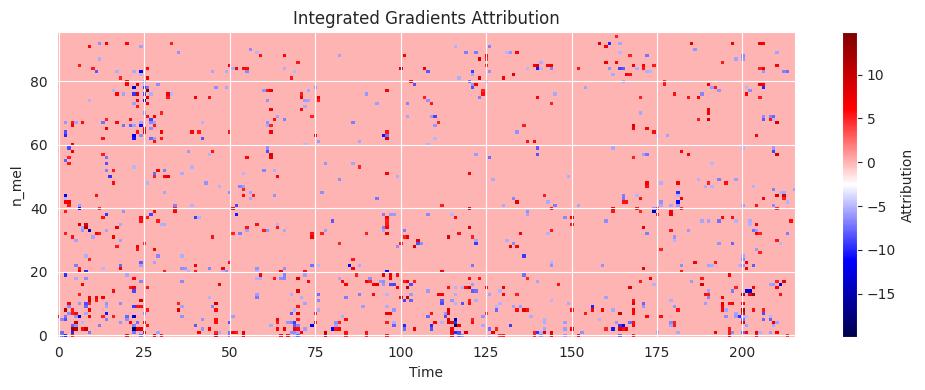

In [187]:
#| code-fold: true
rgba_img, smoothed_mask = highlight_ig_regions(ig_test_map, percentile=95, sigma=0.0)
plt.figure(figsize=(10, 4))
plt.imshow(smoothed_mask, aspect='auto', origin='lower', cmap='seismic')
plt.colorbar(label='Attribution')
plt.title("Integrated Gradients Attribution")
plt.xlabel("Time")
plt.ylabel("n_mel")
plt.tight_layout()
plt.show()


We can see which frequencies in the sample added to the model output.

### Analysis: Why Song A got picked over Song B

We did a lot of work until now. Much of which has been the development of the integrated gradients.

What we were originally interested in is the question of why Song A was chosen over Song B for a query Song.

For this to work, we now need to take our real model, the one that produced the 100D embeddings.

As well as three songs.

- For us this is `Purple Rain` for the query.
- `Mesmerise` for Song A,
- and `Everybody wants to rule the world` for Song B.

Song A and Song B are very close together. While experimenting, I found that using the gradients is challenging in this case.

There are two ways we can calculate contrastive IG.

The standard way: subtract IG

$$
\mathrm{IG}_A(x) = (x - x') \odot \frac{1}{m} \sum_{k=1}^m \nabla_x F_A\left(x' + \frac{k}{m}(x - x')\right)
$$

$$
\mathrm{IG}_B(x) = (x - x') \odot \frac{1}{m} \sum_{k=1}^m \nabla_x F_B\left(x' + \frac{k}{m}(x - x')\right)
$$

$$
\mathrm{ContrastIG}(x) = \mathrm{IG}_A(x) - \mathrm{IG}_B(x)
$$

and method 2 that can be helpful if the embeddings are very close.
The reason is that first taking the gradient and then calculating the difference amplifies the noise. This method has been introduced by [Sundararajan et al. 2017](https://arxiv.org/abs/1703.01365).


The second method uses one scoring function, as described in the Captum interpretability library and aligned with contrastive explanation principles from [Dhurandhar et al. 2018](https://arxiv.org/abs/1802.07623).

$$
F(x) = \text{sim}(x, A) - \text{sim}(x, B)
$$

$$
\mathrm{ContrastIG}(x) = (x - x') \odot \frac{1}{m} \sum_{k=1}^m \nabla_x \left[ F\left(x' + \frac{k}{m}(x - x')\right) \right]
$$

We will try both.

#### Getting the data ready

We need

- load our model: the one that produces the vectors.
- the spectrogram of the query song. The analysis is built on it
- the vector of song A, the best Match. We answer which parts of the query made it go to song A? we use song A as direction of analysis.
- the vector of song B.

In [188]:
model = tf.keras.models.load_model(
    "/app/speccy_model",
    custom_objects={'cosine_proximity': tf.compat.v1.keras.losses.cosine_proximity}
)
model.trainable = False

In [189]:
query_slices = mp3_to_slices("/app/data/raw-previews/combined/Purple Rain - Prince.mp3")
b_slices = mp3_to_slices("/app/data/raw-previews/combined/Everybody Wants To Rule The World - Tears For Fears.mp3")

In [190]:
import pickle

with open("/app/data/pickles/combined/mp3tovecs/mp3tovec.p", "rb") as f:
    mp3tovecs = pickle.load(f)

vec_A = mp3tovecs['/opt/project/data/raw-previews/combined/Mesmerise - Temples.mp3']
vec_B = mp3tovecs['/opt/project/data/raw-previews/combined/Everybody Wants To Rule The World - Tears For Fears.mp3']

Let's confirm shapes

In [191]:
print(query_slices.shape)
print(model.input_shape)
print(vec_A.shape)

(5, 96, 216, 1)
(None, 96, 216, 1)
(100,)


#### Method 1
We first run method 1, using silence as baseline.

In [192]:
ig_raw_a = ig_one_slice_smooth(
    model=model,
    query_slice=query_slices[0:1],
    target_vec=tf.nn.l2_normalize(tf.convert_to_tensor(vec_A, dtype=tf.float32), axis=0),
    baseline_slice=None,
    score_fn=cosine_score_fn,
)

ig_raw_b = ig_one_slice_smooth(
    model=model,
    query_slice=query_slices[0:1],
    target_vec=tf.nn.l2_normalize(tf.convert_to_tensor(vec_B, dtype=tf.float32), axis=0),
    baseline_slice=None,
    score_fn=cosine_score_fn,
)
ig_contrast_method_1 = (ig_raw_a - ig_raw_b)


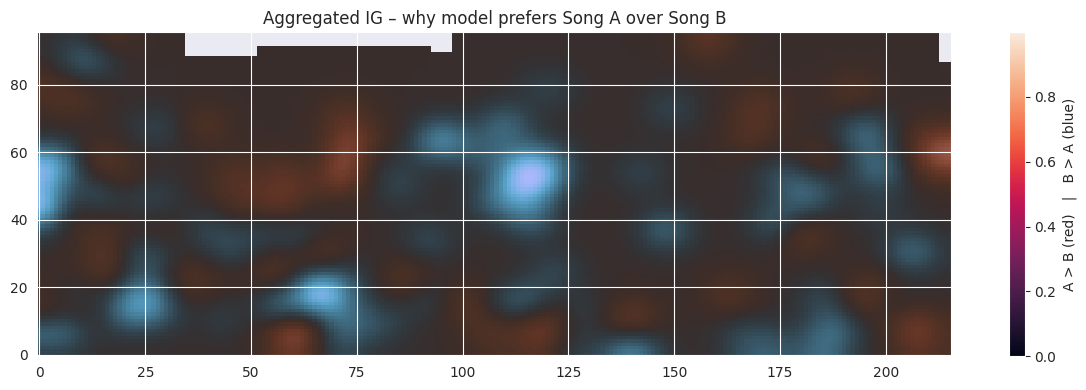

In [193]:
#| code-fold: true
rgba_img, smoothed_mask = highlight_ig_regions(ig_contrast_method_1, percentile=99, sigma=5.0)
plt.figure(figsize=(12, 4))
plt.imshow(rgba_img, origin="lower", aspect="auto")
plt.title("Aggregated IG – why model prefers Song A over Song B")
plt.colorbar(label="A > B (red)   |   B > A (blue)")
plt.tight_layout();
plt.show()


There is not much insight that we can gain from this picture. We will see if the full song analysis can help. We define a function that assembles the full heatmap.

In [194]:
def full_song_contrastive_ig_method1(
        model,
        query_slices,
        vec_A,
        vec_B,
        score_fn,
        steps=120,
        sigma=0,
):
    n_slices, H, W, _ = query_slices.shape
    full_contrast = np.zeros((H, n_slices * W), dtype=np.float32)

    # Normalize target vectors once
    vec_a_tf = tf.nn.l2_normalize(tf.convert_to_tensor(vec_A, dtype=tf.float32), axis=0)
    vec_b_tf = tf.nn.l2_normalize(tf.convert_to_tensor(vec_B, dtype=tf.float32), axis=0)

    # iterate over all slices
    for i in range(n_slices):
        q_slice = query_slices[i:i + 1]

        ig_a = ig_one_slice_smooth(
            model=model,
            query_slice=q_slice,
            target_vec=vec_a_tf,
            baseline_slice=None,
            score_fn=score_fn,
            steps=steps,
            sigma=sigma
        )

        ig_b = ig_one_slice_smooth(
            model=model,
            query_slice=q_slice,
            target_vec=vec_b_tf,
            baseline_slice=None,
            score_fn=score_fn,
            steps=steps,
            sigma=sigma
        )

        ig_contrast = ig_a - ig_b

        full_contrast[:, i * W:(i + 1) * W] = ig_contrast

    return full_contrast
    # (H,W)

... and run it.

In [195]:
full_ig_method_1 = full_song_contrastive_ig_method1(
    model,
    query_slices=query_slices,
    vec_A=vec_A,
    vec_B=vec_B,
    score_fn=cosine_score_fn,
)

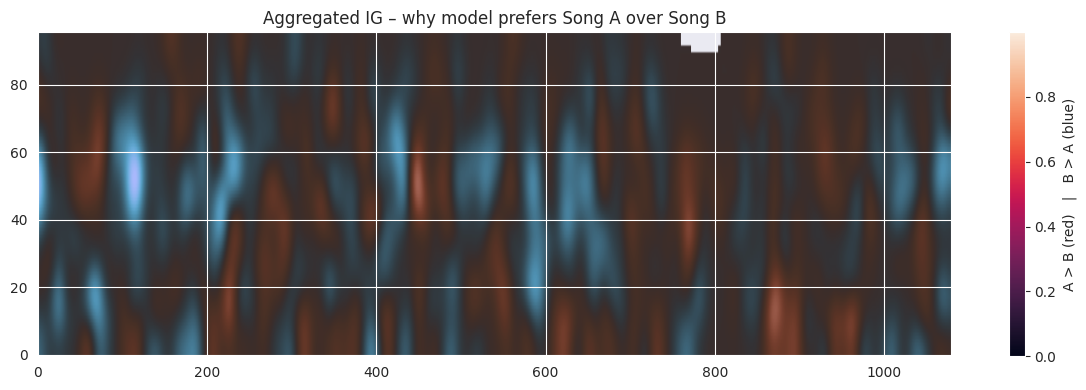

In [196]:
#| code-fold: true
rgba_img, smoothed_mask = highlight_ig_regions(full_ig_method_1, percentile=99, sigma=8.0)
plt.figure(figsize=(12, 4))
plt.imshow(rgba_img, origin="lower", aspect="auto")
plt.title("Aggregated IG – why model prefers Song A over Song B")
plt.colorbar(label="A > B (red)   |   B > A (blue)")
plt.tight_layout()
plt.show()


The result is somewhat disappointing. Overall, the algorithm should have identified song B as the next song. There are only some red spots at the bottom in the lower frequencies.

Let's again switch to a quantitative analysis and plot frequencies in bins.

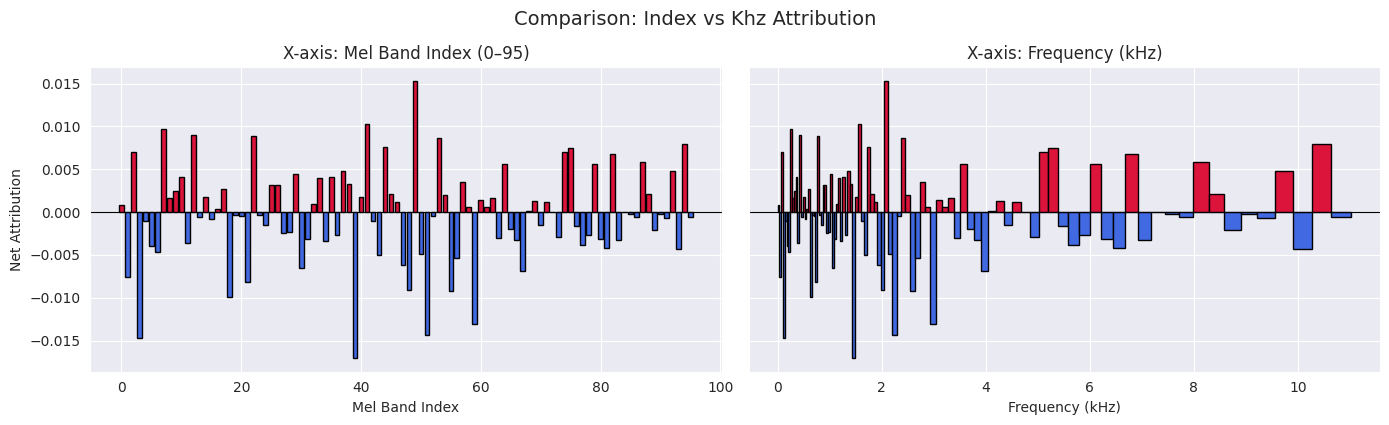

In [197]:
#| code-fold: true
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Simulated IG data, for example,
# Replace with your actual full_ig array
def plot_ig_to_bins(full_ig):
    band = full_ig.sum(axis=1)
    sr = 22050
    num_bins = 96
    # Mel frequency bin edges and centers
    mel_edges = librosa.mel_frequencies(n_mels=full_ig.shape[0] + 1, fmin=0, fmax=sr / 2)

    centres = 0.5 * (mel_edges[1:] + mel_edges[:-1]) / 1000  # in kHz
    mel_widths = np.diff(librosa.hz_to_mel(mel_edges))

    # Color by attribution sign
    colors = np.where(band >= 0, "crimson", "royalblue")
    ig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    new_mel_edges = np.linspace(0, len(band), num_bins + 1, dtype=int)

    # Aggregate original bins into fewer bins
    band_reduced = np.array([
        band[new_mel_edges[i]:new_mel_edges[i + 1]].sum()
        for i in range(num_bins)
    ])

    # Compute centers of the new bins (in kHz)
    mel_centers_reduced = np.array([
        (mel_edges[new_mel_edges[i]] + mel_edges[new_mel_edges[i + 1]]) / 2 / 1000
        for i in range(num_bins)
    ])

    # Colors based on attribution sign
    colors = np.where(band_reduced >= 0, "crimson", "royalblue")

    # --- Left: Simple index-based plot ---
    axs[0].bar(np.arange(len(band)), band, color=colors, edgecolor='black')
    axs[0].set_title("X-axis: Mel Band Index (0–95)")
    axs[0].set_xlabel("Mel Band Index")
    axs[0].set_ylabel("Net Attribution")
    axs[0].axhline(0, color='k', linewidth=0.8)

    # --- Right: Mel-scale-accurate plot ---
    plt.bar(mel_centers_reduced, band_reduced,
            width=np.diff(mel_edges[new_mel_edges]) / 1000,
            color=colors, edgecolor='black')
    axs[1].set_title("X-axis: Frequency (kHz)")
    axs[1].set_xlabel("Frequency (kHz)")
    axs[1].axhline(0, color='k', linewidth=0.8)

    plt.tight_layout()
    plt.suptitle("Comparison: Index vs Khz Attribution", y=1.05, fontsize=14)
    plt.show()


plot_ig_to_bins(full_ig_method_1)


The heatmap is transformed into two barcharts:

- As mel band index (aligned with the vertical axis of the IG heatmap)

- Converted to real-world frequency in kHz. We can see the nonlinear nature of the mel scale from this.


Both songs seem quite balanced in terms of attribution. It is not clear why the song was picked.

One potential reason: The embeddings are very close. Therefore, the noise in the gradient generation dominates.
We can rerun the analysis with smoothing per slice.

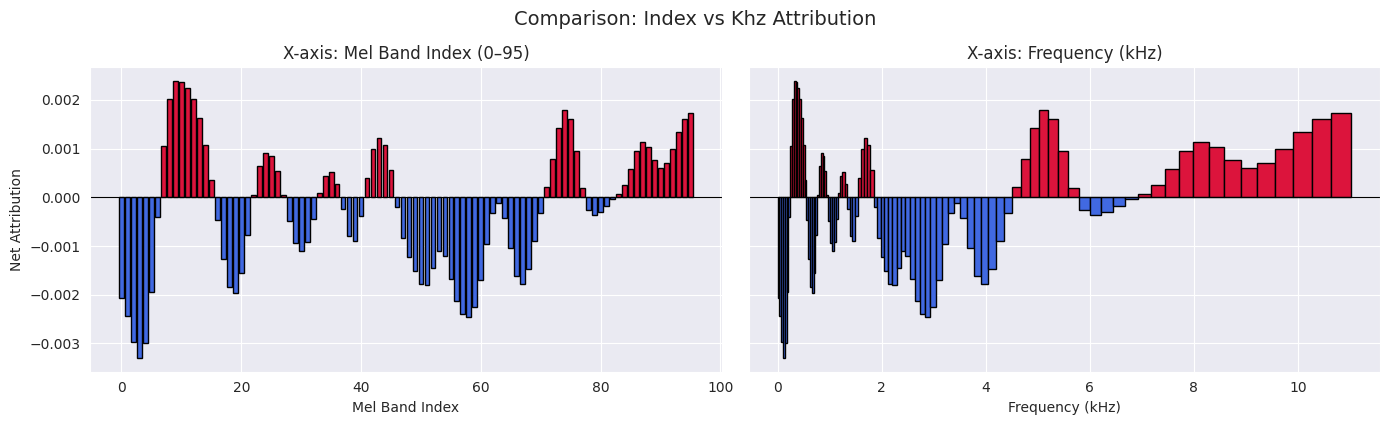

In [198]:
#| code-fold: true
full_ig_method_1_smoothed = full_song_contrastive_ig_method1(
    model,
    query_slices=query_slices,
    vec_A=vec_A,
    vec_B=vec_B,
    score_fn=cosine_score_fn,
    sigma=2.0
)
plot_ig_to_bins(full_ig_method_1_smoothed)

The smoothing made the graphs easier to read. Attribution is very low. Song B is better in the low frequencies. Whereas a song A is better in the high frequencies. The graphs look nice, but there is a catch... Let's look at method2 first.

#### Method 2

In the presence of weak gradients, method 2 suggests not calculating extra differences but using a single scoring function. This is done by making song B the baseline.

##### Implementation

In [199]:

def full_song_ig_method_2(
        model,
        query_slices,
        vec_A,
        baseline_slices,
        score_fn,
        steps=120,
        sigma=0
):
    n_slices, H, W, _ = query_slices.shape
    full_contrast = np.zeros((H, n_slices * W), dtype=np.float32)

    # Normalize target vectors once
    vecA_tf = tf.nn.l2_normalize(tf.convert_to_tensor(vec_A, dtype=tf.float32), axis=0)

    for i in range(n_slices):
        q_slice = query_slices[i:i + 1]
        b_slice = baseline_slices[i:i + 1]

        ig_slice_m2 = ig_one_slice_smooth(
            model=model,
            query_slice=q_slice,
            target_vec=vecA_tf,
            baseline_slice=b_slice,
            score_fn=score_fn,
            steps=steps,
            sigma=sigma
        )

        full_contrast[:, i * W:(i + 1) * W] = ig_slice_m2.squeeze()

    return full_contrast


##### Without Filtering

In [200]:
#| code-fold: true
full_ig_method_2 = full_song_ig_method_2(
    model,
    query_slices=query_slices,
    vec_A=vec_A,
    baseline_slices=b_slices,
    score_fn=cosine_score_fn,
)

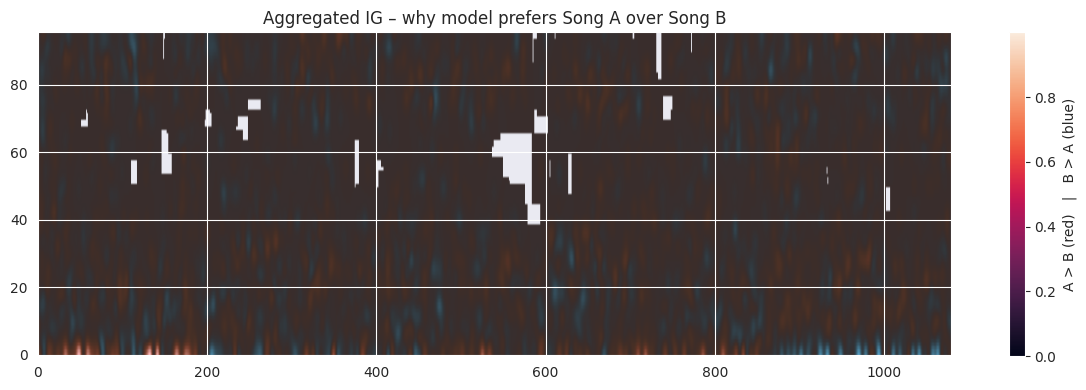

In [201]:
#| code-fold: true
rgba_img, smoothed_mask = highlight_ig_regions(full_ig_method_2, percentile=95, sigma=2.5)
plt.figure(figsize=(12, 4))

plt.imshow(rgba_img, origin="lower", aspect="auto")
plt.title("Aggregated IG – why model prefers Song A over Song B")
plt.colorbar(label="A > B (red)   |   B > A (blue)")
plt.tight_layout();
plt.show()


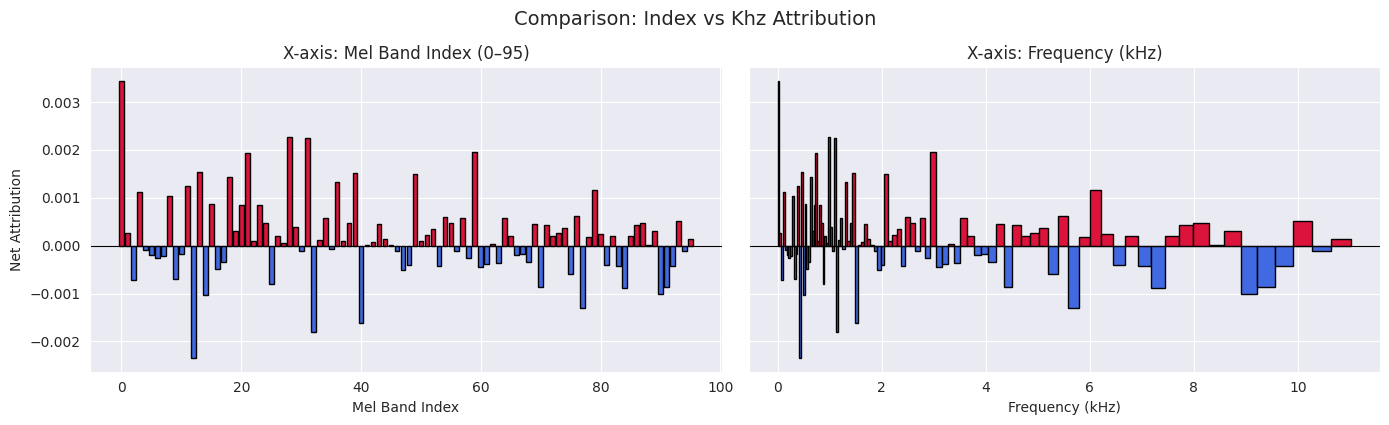

In [202]:
#| code-fold: true
plot_ig_to_bins(full_ig_method_2)

#### With Filtering

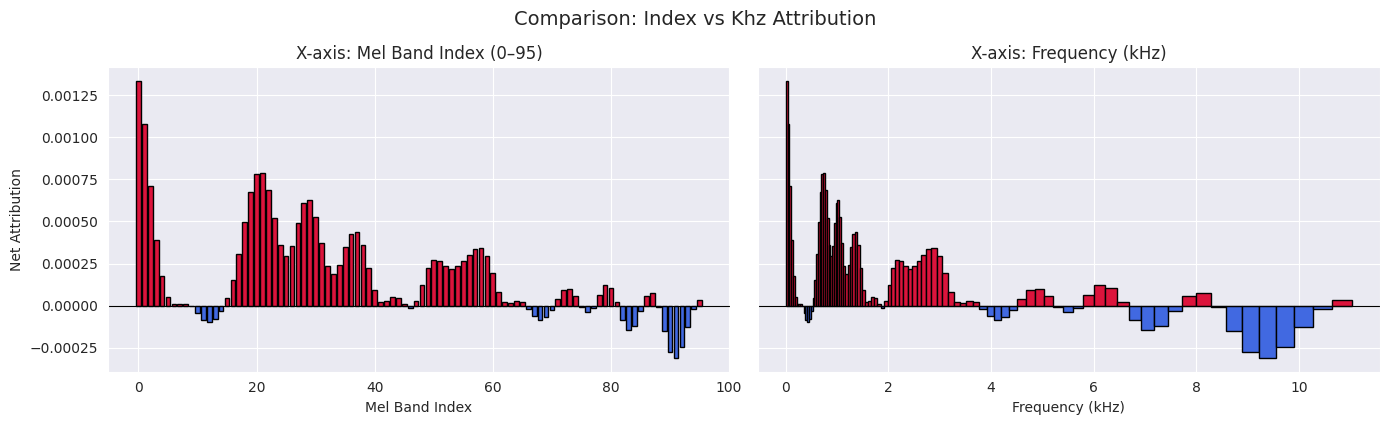

In [203]:
full_ig_method_2_smoothed = full_song_ig_method_2(
    model,
    query_slices=query_slices,
    vec_A=vec_A,
    baseline_slices=b_slices,
    score_fn=cosine_score_fn,
    sigma=2.0
)
plot_ig_to_bins(full_ig_method_2_smoothed)

Now, Song A is favored in the lower frequencies, while Song B shows more influence in the upper bands.

### Conclusion Method 1 vs. Method 2
One possible reason why Method 1 (subtracting filtered IGs) gives misleading results:
If we apply Gaussian filtering before computing the difference, we might distort subtle but meaningful gradients. Since the raw attributions are weak overall, smoothing may disproportionately amplify or suppress regions — leading to an inaccurate contrast map.
In fact, the raw IG maps for A and B look much more similar, and only diverge sharply after filtering.


This suggests that Method 2, which uses a single contrastive score function (sim(x, A) - sim(x, B)), is more stable and reliable in cases where the attribution signal is weak and gradients are low.

### Interpretation
Assuming Method 2 provides the correct contrastive explanation, we can proceed with an interpretation.
Overall, a Song A is a much better match in the low and mid-frequencies. These findings suggest that the song A's similarity to the query (in this case, Purple Rain) is driven by features like kick drums, basslines, or low-mid instrumentation — all of which live in those bands.

Between 5 kHz and 9 kHz, we see increasing attribution for Song B.
These frequencies often correspond to vocals, snares, cymbals, or presence-related features.

Interestingly, I listened to the tracks on a phone-conference headset, which emphasizes exactly that frequency range. So this auditory similarity aligns with what we hear — and validates the contrastive IG result.


## Summary
### What did we learn?
T-SNE analysis showed no clear clusters labeled “silent” or “party.” My subjective categories don’t appear to have a strong representation in the embedding space — at least not visibly

For two nearly identical songs:

- T-SNE placed their embeddings close together in 2D space, confirming high similarity.

- Grad-CAM revealed that Song A (the model’s top match) contained more regions that aligned well with the query’s audio features.

- Integrated Gradients highlighted that Song A had stronger matches in the lower frequencies, whereas my personal impression focused on higher-frequency features where Song B was better.

### Take away

Streaming platforms don’t just recommend popular songs; they can also suggest new or unknown music by analyzing the audio content directly through audio embeddings.
While commercial systems use more advanced models and larger infrastructure, the core principles are the same as the methods demonstrated here. In addition, platforms incorporate collaborative filtering, user history, and social data to drive final recommendations.

What started as an experiment with a small CNN and a few audio clips turned into a concrete example of how machines “hear” music. Deep learning allows us to go beyond surface-level metadata like genre or artist, learning fine-grained acoustic patterns directly from the audio.

By exploring techniques like Grad-CAM, Integrated Gradients, and embedding visualization, we’ve opened a window into how machine learning models make decisions about music — and how we can interpret those decisions.

This type of analysis helps explain:

- Why a recommendation "feels right"; even if you can’t explain it yourself

- Why playlist transitions often make musical sense, even when songs come from different genres



If a basic model trained on a few spectrogram slices can already show interpretable behavior, imagine the scale and nuance of systems like Spotify, Apple Music, or TikTok.

This project isn’t just about “how one match happened.”
It’s a glimpse into how modern recommendation systems think. Understanding these systems is important for a thoughtful usage.